# Modelling

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [44]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, RatingSVD, LogisticSVD
from RecData import RecData

## Data Preprocessing

In [45]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482532, 3)


app_id  is_recommended  user_id
629351    12210            True      240
116928    22380            True      240
1418125  239140            True      240
236273   251570            True      240
87206    270880            True      240

In [46]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# # del recs

# start_time = time.time()
# print("Creating splits...")
# train_data, test = rec_data.train_test_split(test_size=0.2)
# print("First split done.")
# train_data, val = train_data.train_test_split(test_size=0.2)
# print("Done creating splits in", time.time() - start_time, "seconds")

In [47]:
random.seed(42)
np.random.seed(42)
rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

print("Creating splits...")
train_data, val = rec_data.leave_k_out_split(k=1, create_val=False)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
Done user 1 / 63175
Done user 10001 / 63175
Done user 20001 / 63175
Done user 30001 / 63175
Done user 40001 / 63175
Done user 50001 / 63175
Done user 60001 / 63175
Done creating splits.


In [48]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [49]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [50]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

Epoch 0/Training loss: 0.4487495294647828/Validation loss: 0.4500651174940296/Time: 6.47 seconds
Epoch 1/Training loss: 0.43180330958383484/Validation loss: 0.4357015936842853/Time: 6.73 seconds
Epoch 2/Training loss: 0.42195182539089593/Validation loss: 0.4279007370303981/Time: 6.72 seconds
Epoch 3/Training loss: 0.4143795406999648/Validation loss: 0.42217743465772584/Time: 6.57 seconds
Epoch 4/Training loss: 0.40807110752655584/Validation loss: 0.4173242630149245/Time: 6.74 seconds
Epoch 5/Training loss: 0.40259475754258256/Validation loss: 0.41310224055989736/Time: 6.6 seconds
Epoch 6/Training loss: 0.3977890788168256/Validation loss: 0.40945792013031096/Time: 6.66 seconds
Epoch 7/Training loss: 0.393452379749008/Validation loss: 0.4062639892188958/Time: 6.76 seconds
Epoch 8/Training loss: 0.3894850072070223/Validation loss: 0.4031450036223637/Time: 6.69 seconds
Epoch 9/Training loss: 0.38591737410425414/Validation loss: 0.4004552161681068/Time: 6.67 seconds
Epoch 10/Training loss: 

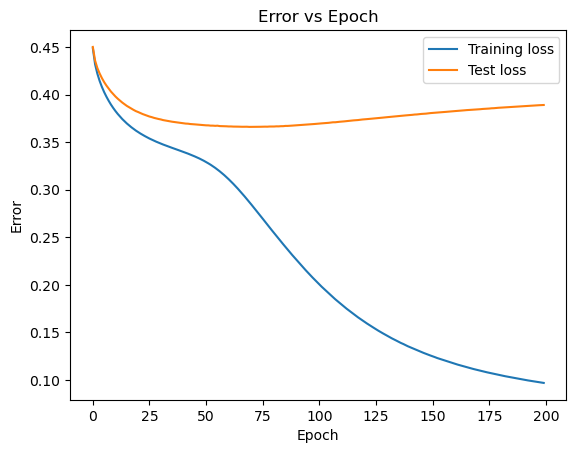

Validation rmse 0.3466832982054145


In [51]:
# for pruned, epoch: 60, lr:0.01, reg:0.02, k=80
# for 2plus, epoch: 80, lr:0.01, reg:0.02, k=100

EPOCHS = 200

random.seed(42)
np.random.seed(42)

# # Fit and predict with svd
# svd_predictor = RatingSVD(
#     train_data.get_num_users(), train_data.get_num_items(), 2, k=10, 
#     learning_rate=0.001, C=0.02)
# svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=100, 
    learning_rate=0.01, C=0.02)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training loss')
plt.plot(range(len(val_errors)), val_errors, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Validation rmse", rmse)

We can now continue to train if we believe the model is still underfitting.

In [14]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training loss: 0.28433201799265634/Validation loss: 0.3660426553970474/Time: 6.78 seconds
Epoch 1/Training loss: 0.2813900702397608/Validation loss: 0.3660159817899922/Time: 6.62 seconds
Epoch 2/Training loss: 0.27841887087646944/Validation loss: 0.366154755309313/Time: 6.49 seconds
Epoch 3/Training loss: 0.27546529827889404/Validation loss: 0.3661130871057611/Time: 6.5 seconds
Epoch 4/Training loss: 0.27246802250726404/Validation loss: 0.3661658192868336/Time: 6.55 seconds


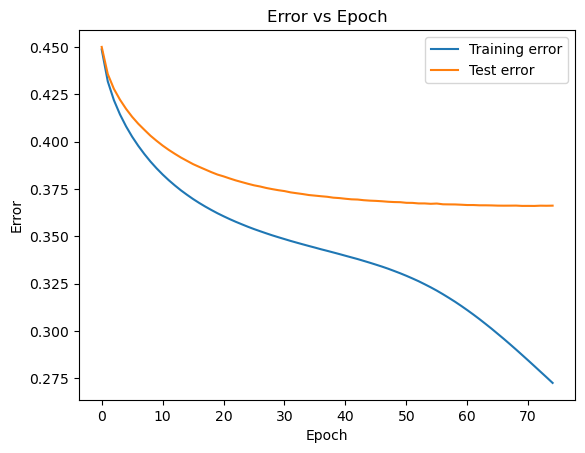

Test rmse 0.3385298250412219


In [16]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [52]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 1 / 2246
Upto row 201 / 2246
Upto row 401 / 2246
Upto row 601 / 2246
Upto row 801 / 2246
Upto row 1001 / 2246
Upto row 1201 / 2246
Upto row 1401 / 2246
Upto row 1601 / 2246
Upto row 1801 / 2246
Upto row 2001 / 2246
Upto row 2201 / 2246
Done computing similarities in 408.8218936920166 seconds


## Preparing for Production

In [41]:
svd_predictor.prep_for_item_knn()
train_data.prep_for_item_knn()

## Saving the model

In [42]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [2]:
with open('saved_models/2023-7-8-12-15-13_0-37.pkl', 'rb') as file:
    train_data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

In [54]:
train_data.search_title('skyrim')

[('The Elder Scrolls V: Skyrim VR', 661),
 ('The Elder Scrolls V: Skyrim Special Edition', 147)]

In [55]:
top = svd_predictor.items_knn([(147, 1)], n=1)
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.4535417303563537, 'Onmyoji'),
 (0.4483154553489226, 'Sport Mode'),
 (0.43492520791998135, 'Fallout 4'),
 (0.3593990558289475, 'The Jackbox Party Pack 6'),
 (0.3499126705597935, 'Samurai Jack: Battle Through Time'),
 (0.3472801644521669, 'Virtual Circuit Board'),
 (0.307158560986123, 'Disciples Sacred Lands Gold'),
 (0.3051483247176039, 'Turing Complete'),
 (0.3050459811590404, 'Crisis Brigade 2 reloaded'),
 (0.30477866235108986, 'Devil May Cry 5')]


In [13]:
svd_predictor._user_features[0, :]
svd_predictor._item_features[1066, :]
np.max(svd_predictor._user_biases)
np.max(svd_predictor._item_biases)
# np.max(svd_predictor._item_features)

0.9472438167803995

In [40]:
j = 1

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 10)
print("Predicted top n:")
pprint([index for r, index in top_n])
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[757, 972, 461, 666, 1701, 1652, 270, 1237, 123, 33]
[(0.9946229413952719, 'Portal 2'),
 (0.9908505947890028, 'A Hat in Time'),
 (0.984483899531803, 'Terraria'),
 (0.9839634762553195, 'POSTAL 2'),
 (0.9744107363645287, 'Thief™ II: The Metal Age'),
 (0.9734108580607946, 'Mafia II (Classic)'),
 (0.9707337720158055, 'Lil Gator Game'),
 (0.9689356149386221, 'DOOM (1993)'),
 (0.9680847946927481, 'Glass Masquerade'),
 (0.9668629025098278, 'Monolith')]
True top n:
['Dungeon Warfare 2',
 'Chivalry 2',
 'Warhammer: Vermintide 2',
 'Streets of Rogue',
 'Orcs Must Die! 3',
 'Cosmoteer: Starship Architect & Commander',
 'Deep Rock Galactic',
 'Gunfire Reborn',
 'Men of War: Assault Squad 2',
 'Ruinarch',
 'Going Medieval',
 'Battle Cry of Freedom',
 'Warhammer 40000: Darktide',
 'Cyberpunk 2077',
 'Crusader Kings III',
 'Squad',
 'Holdfast: Nations At War',
 'Ultimate Admiral: Dreadnoughts']


In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [46]:
train_data.search_title('GunPoint')

[('Gunpoint', 1066)]

In [21]:
prefs = [(147, 1), (325, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(147, 'The Elder Scrolls V: Skyrim Special Edition', 1),
 (325, 'Slay the Spire', 1)]


In [22]:
epochs = 1

start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=epochs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Time: 6.88 seconds
Completed partial fit in 7.875029563903809 seconds


In [28]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 10)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9987608146858127, 'Portal 2'),
 (0.9969967969293526, 'A Hat in Time'),
 (0.9952055750129399, 'Terraria'),
 (0.9939231456186107, 'Thief™ II: The Metal Age'),
 (0.9938464256065681, 'Lil Gator Game'),
 (0.9936272229187082, 'Mafia II (Classic)'),
 (0.9934598331074666, 'POSTAL 2'),
 (0.9909451404418662, 'Monolith'),
 (0.9907963903985133, 'Choice of Robots'),
 (0.9907266718244505, 'Bastion')]
